In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
from torchvision.transforms import ToTensor, Resize, ToPILImage
from torchvision.transforms.functional import rotate
import matplotlib as mpl
from PIL import Image
from escnn import gspaces
from escnn import nn
import math

import os
if os.path.basename(os.getcwd()) != '615Project':
    os.chdir('..')
    
from data.dataset import MnistRotDataset, FilteredMNIST
from models.C8SteerableCNN import C8SteerableCNN
from models.StandardCNN import StandardCNN
from models.C4SteerableCNN import C4SteerableCNN
from models.C4CNN import C4CNN
from models.SO2SteerableCNN import SO2SteerableCNN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [343]:
model = C4SteerableCNN()
params = torch.load("saved_models/C4SteerableCNN.pt", map_location=torch.device('cpu'))
model.load_state_dict(params)

C8Steerable_model = C8SteerableCNN()
params = torch.load("saved_models/C8SteerableCNN.pt", map_location=torch.device('cpu'))
C8Steerable_model.load_state_dict(params)

C4CNN_model = C4CNN()
params = torch.load("saved_models/C4CNN_MnistRotDataset.pt", map_location=torch.device('cpu'))
C4CNN_model.load_state_dict(params)

SO2CNN_model = SO2SteerableCNN()
params = torch.load("saved_models/SO2SteerableCNN.pt", map_location=torch.device('cpu'))
SO2CNN_model.load_state_dict(params)

StandardCNN_model = StandardCNN()
params = torch.load("saved_models/StandardCNN.pt", map_location=torch.device('cpu'))
StandardCNN_model.load_state_dict(params)

<All keys matched successfully>

In [336]:
test_set = MnistRotDataset('test', ToTensor())
only_6 = FilteredMNIST(test_set, 6)

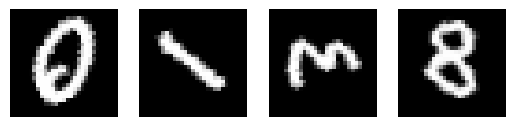

In [220]:
fig, axes = plt.subplots(1, 4)
indexes = [1, 8, 14, 22]
map_num = 8
for col, i in enumerate(indexes):
    im, label = test_set[i]
    axes[col].imshow(im[0, :, :].numpy(), cmap=mpl.cm.gray)
    axes[col].axis("off")


In [251]:
img, label = only_6[8]
label

6

(-0.5, 28.5, 28.5, -0.5)

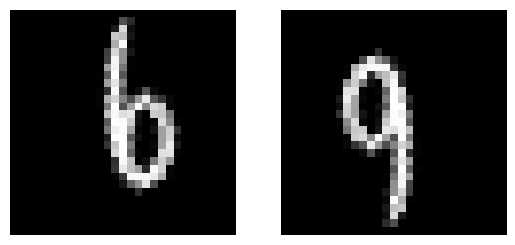

In [255]:

fig, axes = plt.subplots(1, 2)
axes[0].imshow(img[0, :, :].rot90(0, dims=(-2, -1)).numpy()[:, ::-1], cmap=mpl.cm.gray)
axes[0].axis("off")
axes[1].imshow(img[0, :, :].rot90(2, dims=(-2, -1)).numpy()[:, ::-1], cmap=mpl.cm.gray)
axes[1].axis("off")


In [123]:
image, label = test_set[15]
preds = []
maps = []
imgs = []
with torch.no_grad():
    model.eval()
    for r in range(4):
        rot_img = image.rot90(r, dims=(-2, -1))
        imgs.append(rot_img)
        pred, feat_maps = model(rot_img.unsqueeze(0))
        preds.append(pred)
        maps.append(feat_maps)

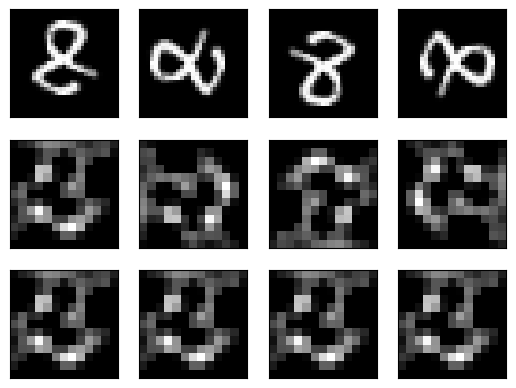

In [129]:
fig, axes = plt.subplots(3, 4)

map_num = 8
for col in range(4):
    axes[0, col].imshow(imgs[col][0, :, :].numpy(), cmap=mpl.cm.gray)
    axes[1, col].imshow(maps[col].tensor.numpy()[0, map_num + col, :, :], cmap=mpl.cm.gray)
    axes[2, col].imshow(maps[col].tensor.rot90(-col, dims=(-2, -1)).numpy()[0, map_num + col, :, :], cmap=mpl.cm.gray)
    for row in range(3):
        axes[row, col].set_xticks([])
        axes[row,col].set_yticks([])

In [130]:
for pred in preds:
    print(torch.nn.functional.softmax(pred)[0,8])

tensor(0.9850)
tensor(0.9850)
tensor(0.9850)
tensor(0.9850)


/var/folders/sj/z3jsbwgn7ng6p_t1hv2vhxyw0000gn/T/ipykernel_71309/943367260.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.nn.functional.softmax(pred)[0,8])


In [339]:
C8_val = np.load("saved_models/C8SteerableCNN_val_acc.npy")
C8_time = np.linspace(0, 479.159, len(C8_val))
C4_val = np.load("saved_models/C4SteerableCNN_val_acc.npy")
C4_time = np.linspace(0, 216.884, len(C4_val))
Standard_val = np.load("saved_models/StandardCNN_val_acc.npy")
Standard_time = np.linspace(0, 150.692, len(Standard_val))
C4_discrete = np.load("saved_models/C4CNN_val_acc.npy")
C4_discrete_time = np.linspace(0, 1274.919, len(C4_discrete))
SO2_val = np.load("saved_models/SO2SteerableCNN_val_acc.npy")
SO2_time = np.linspace(0, 1602.315, len(SO2_val))

Text(0.5, 1.0, 'Validation Accuracy')

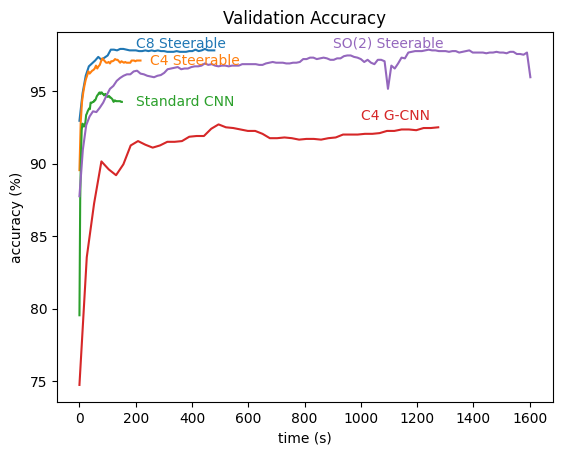

In [340]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.plot(C8_time, C8_val, label="C8 Steerable")
plt.annotate("C8 Steerable", (200, 98), color = colors[0])
plt.plot(C4_time, C4_val, label="90 Rotation Invariant")
plt.annotate("C4 Steerable", (250, 96.8), color = colors[1])
plt.plot(Standard_time, Standard_val, label="Standard CNN")
plt.annotate("Standard CNN", (200, 94), color = colors[2])
plt.plot(C4_discrete_time, C4_discrete, label="Discrete 90 Rotation Invariant")
plt.annotate("C4 G-CNN", (1000, 93), color = colors[3])
plt.plot(SO2_time, SO2_val, label="Continuous Rotation Invariant")
plt.annotate("SO(2) Steerable", (900, 98), color = colors[4])

plt.xlabel("time (s)")
plt.ylabel("accuracy (%)")
plt.title("Validation Accuracy")


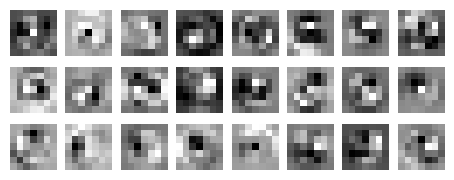

In [442]:
conv_weights = model.block1[1].export().weight

conv_weights_np = conv_weights.cpu().detach().numpy()

conv_weights_np = (conv_weights_np - conv_weights_np.min()) / (conv_weights_np.max() - conv_weights_np.min())

n_filters = conv_weights_np.shape[0]
n_channels = conv_weights_np.shape[1]

n_rows, n_cols = 3, 8
image_size = 7

scaling_factor = 10
fig_width = n_cols * image_size * scaling_factor / 100
fig_height = n_rows * image_size * scaling_factor / 100 
fig, axes = plt.subplots(3, 8, figsize=(fig_width, fig_height))

for i in range(24):
    row = i // 8
    col = i % 8
    ax = axes[row, col]
    ax.imshow(conv_weights_np[i*4, 0], cmap='gray')
    ax.axis('off')

plt.show()

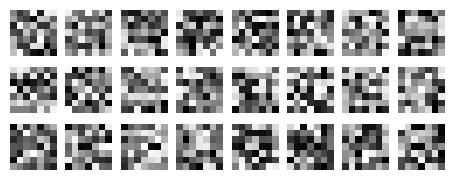

In [443]:
standardCNN = StandardCNN()
params = torch.load("saved_models/StandardCNN.pt", map_location=torch.device('cpu'))
standardCNN.load_state_dict(params)

conv_weights = standardCNN.block1[0].weight

conv_weights_np = conv_weights.cpu().detach().numpy()

conv_weights_np = (conv_weights_np - conv_weights_np.min()) / (conv_weights_np.max() - conv_weights_np.min())

n_filters = conv_weights_np.shape[0]
n_channels = conv_weights_np.shape[1]


fig, axes = plt.subplots(3, 8, figsize=(fig_width, fig_height))

for i in range(24):
    row = i // 8
    col = i % 8
    ax = axes[row, col]
    ax.imshow(conv_weights_np[i, 0], cmap='gray')
    ax.axis('off')

plt.show()

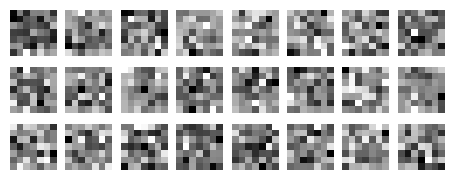

In [444]:
conv_weights = C4CNN_model.block1[0].weight

conv_weights_np = conv_weights.cpu().detach().numpy()

conv_weights_np = (conv_weights_np - conv_weights_np.min()) / (conv_weights_np.max() - conv_weights_np.min())

n_filters = conv_weights_np.shape[0]
n_channels = conv_weights_np.shape[1]


fig, axes = plt.subplots(3, 8, figsize=(fig_width, fig_height))

for i in range(24):
    row = i // 8
    col = i % 8
    ax = axes[row, col]
    ax.imshow(conv_weights_np[i, 0], cmap='gray')
    ax.axis('off')

plt.show()

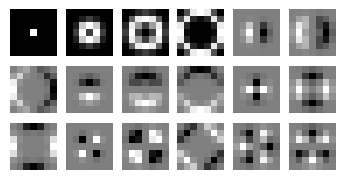

In [403]:
image_size = 7
n_rows = 3
n_cols = 6

scaling_factor = 10
fig_width = n_cols * image_size * scaling_factor / 100 
fig_height = n_rows * image_size * scaling_factor / 100


fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

for i in range(n_rows * n_cols):
    weights = torch.zeros((432))
    weights[i] = 1
    basis = model.block1[1]._basisexpansion(weights)
    row = i // n_cols
    col = i % n_cols 
    axes[row, col].imshow(basis[1, 0, :].reshape(7, 7), cmap='gray')
    axes[row, col].axis("off")



In [72]:
resize1 = Resize(87)
resize2 = Resize(29)
totensor = ToTensor()
topill = ToPILImage()

image, label = test_set[15]
image = topill(resize1(image))
preds = []
maps = []
imgs = []
with torch.no_grad():
    SO2CNN_model.eval()
    for r in range(16):
        rot_img = totensor(resize2(rotate(image, r*45., Image.BILINEAR))).reshape(1, 1, 29, 29)
        imgs.append(rot_img)
        pred, feat_maps = SO2CNN_model(rot_img)
        preds.append(pred)
        maps.append(feat_maps)

/Users/dylanmiller/miniforge3/envs/GCNN/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


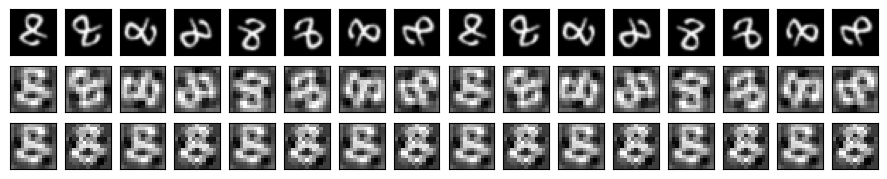

In [75]:
image_size = 7
n_rows = 3
n_cols = 16

scaling_factor = 10
fig_width = n_cols * image_size * scaling_factor / 100 
fig_height = n_rows * image_size * scaling_factor / 100

fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

map_num = 0
for col in range(16):
    axes[0, col].imshow(imgs[col][0, 0, :, :].numpy(), cmap=mpl.cm.gray)
    axes[1, col].imshow(maps[col].tensor.numpy()[0, map_num, :, :], cmap=mpl.cm.gray)
    map = topill(maps[col].tensor.numpy()[0, map_num, :, :])
    rot_map = np.array(rotate(map, -col*45))
    axes[2, col].imshow(rot_map, cmap=mpl.cm.gray)
    #axes[2, col].imshow(maps[col].tensor.rot90(-col, dims=(-2, -1)).numpy()[0, map_num + col, :, :], cmap=mpl.cm.gray)
    for row in range(3):
        axes[row, col].set_xticks([])
        axes[row,col].set_yticks([])

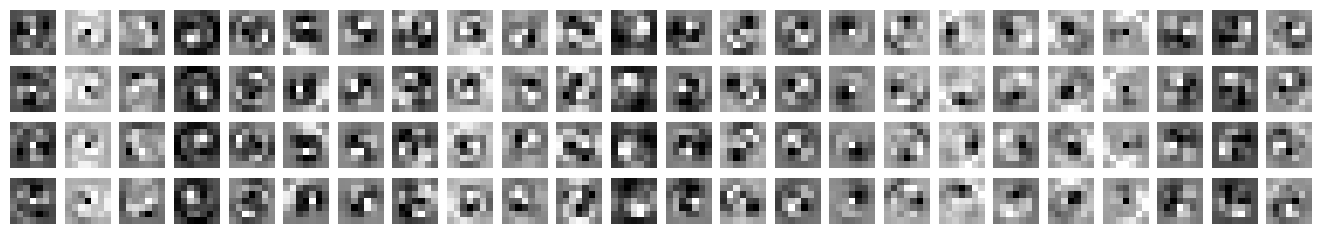

In [129]:
conv_weights = model.block1[1].export().weight


conv_weights_np = conv_weights.cpu().detach().numpy()

conv_weights_np = (conv_weights_np - conv_weights_np.min()) / (conv_weights_np.max() - conv_weights_np.min())

n_filters = conv_weights_np.shape[0]
n_channels = conv_weights_np.shape[1]

n_rows, n_cols = 4, 24
image_size = 7

scaling_factor = 10
fig_width = n_cols * image_size * scaling_factor / 100 
fig_height = n_rows * image_size * scaling_factor / 100 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

for i in range(n_rows * n_cols):
    row = i % n_rows
    col = i // n_rows
    ax = axes[row, col]
    ax.imshow(conv_weights_np[i, 0], cmap='gray')
    ax.axis('off')

plt.show()

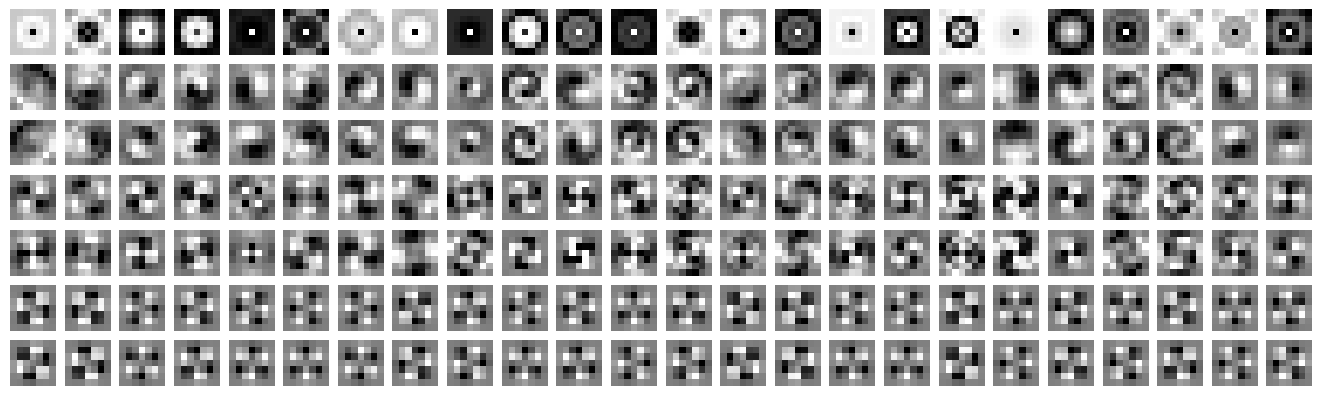

In [128]:
SO2CNN_model.eval()
conv_weights = SO2CNN_model.block1[0].export().weight

conv_weights_np = conv_weights.cpu().detach().numpy()

conv_weights_np = (conv_weights_np - conv_weights_np.min()) / (conv_weights_np.max() - conv_weights_np.min())

n_filters = conv_weights_np.shape[0]
n_channels = conv_weights_np.shape[1]

n_rows, n_cols = 7, 24
image_size = 7

scaling_factor = 10
fig_width = n_cols * image_size * scaling_factor / 100 
fig_height = n_rows * image_size * scaling_factor / 100 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

for i in range(n_rows * n_cols):
    row = i % n_rows
    col = i // n_rows
    ax = axes[row, col]
    ax.imshow(conv_weights_np[i, 0], cmap='gray')
    ax.axis('off')

plt.show()

In [286]:

r2_act = gspaces.rot2dOnR2(N=-1)
G = r2_act.fibergroup
W = 29
x = torch.randn(1, 1, W, W)


def build_mask(W):
    center_mask = np.zeros((2, W, W))
    center_mask[1, :, :] = np.arange(0, W) - W // 2
    center_mask[0, :, :] = np.arange(0, W) - W // 2
    center_mask[0, :, :] = center_mask[0, :, :].T
    center_mask = center_mask[0, :, :] ** 2 + center_mask[1, :, :] ** 2 < .9*(W // 2) ** 2
    center_mask = torch.tensor(center_mask.reshape(1, 1, W, W), dtype=torch.float)
    return center_mask


input_center_mask = build_mask(W)

x = x * input_center_mask

N = 100

feat_type_in = nn.FieldType(r2_act, [G.trivial_representation])
feat_type_out = nn.FieldType(r2_act, [G.trivial_representation])

models = {
    "Standard CNN": StandardCNN_model.eval(),
    "C4 G-CNN": C4CNN().eval(),
    "C4 Steerable": model.eval(), 
    "C8 Steerable": C8Steerable_model.eval(),
    "SO2 Steerable": SO2CNN_model.eval()
}


with torch.no_grad():
    y = {k: feat_type_out(m(x)[1]) for k, m in models.items()}
output_center_mask = build_mask(y['C8 Steerable'].shape[-1])
errors = {k: [] for k in models.keys()}

x = feat_type_in(x)

for i in range(N+1):
    rot = i / N * 2*np.pi
    g = G.element(rot)

    x_transformed = x.transform(g)
    x_transformed.tensor *= input_center_mask

    for method, m in models.items():
        with torch.no_grad():
            y_from_x_transformed = m(x_transformed.tensor, rot)[1]

        y_transformed_from_x = y[method].transform(g)

        y_from_x_transformed = y_from_x_transformed * output_center_mask
        y_transformed_from_x = y_transformed_from_x.tensor * output_center_mask

        rel_error = torch.norm(y_from_x_transformed - y_transformed_from_x).item() / torch.norm(y[method].tensor).item()

        errors[method].append(rel_error)



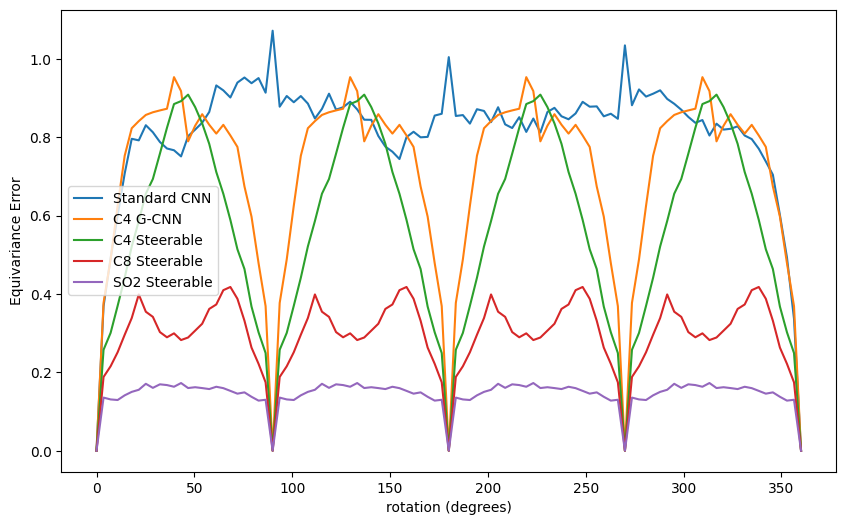

In [293]:
fig, ax = plt.subplots(figsize=(10, 6))

xs = [math.degrees(i*2*np.pi / N) for i in range(N+1)]
for method, error in errors.items():
    plt.plot(xs, error, label=method)

plt.xlabel("rotation (degrees)")
plt.ylabel('Equivariance Error')
plt.legend()
plt.show()

In [345]:

r2_act = gspaces.rot2dOnR2(N=-1)
G = r2_act.fibergroup
W = 29

image, label = test_set[15]


def build_mask(W):
    center_mask = np.zeros((2, W, W))
    center_mask[1, :, :] = np.arange(0, W) - W // 2
    center_mask[0, :, :] = np.arange(0, W) - W // 2
    center_mask[0, :, :] = center_mask[0, :, :].T
    center_mask = center_mask[0, :, :] ** 2 + center_mask[1, :, :] ** 2 < .9*(W // 2) ** 2
    center_mask = torch.tensor(center_mask.reshape(1, 1, W, W), dtype=torch.float)
    return center_mask


input_center_mask = build_mask(W)

x = image * input_center_mask

N = 100

def cosine_similarity(vec1, vec2):
    dot_product = torch.dot(vec1, vec2)
    magnitude_vec1 = torch.linalg.norm(vec1)
    magnitude_vec2 = torch.linalg.norm(vec2)
    similarity = dot_product / (magnitude_vec1 * magnitude_vec2)
    return similarity

feat_type_in = nn.FieldType(r2_act, [G.trivial_representation])
feat_type_out = nn.FieldType(r2_act, [G.trivial_representation])

models = {
    "Standard CNN": StandardCNN_model.eval(),
    "C4 G-CNN": C4CNN_model.eval(),
    "C4 Steerable": model.eval(), 
    "C8 Steerable": C8Steerable_model.eval(),
    "SO2 Steerable": SO2CNN_model.eval()
}


with torch.no_grad():
    y = {k: m(x)[0] for k, m in models.items()}
errors = {k: [] for k in models.keys()}

x = feat_type_in(x)

softmax = torch.nn.functional.softmax

for i in range(N+1):
    rot = i / N * 2*np.pi
    g = G.element(rot)

    x_transformed = x.transform(g)
    x_transformed.tensor *= input_center_mask

    for method, m in models.items():
        with torch.no_grad():
            y_from_x_transformed = m(x_transformed.tensor, rot)[0]

        y_transformed_from_x = y[method]

        rel_error = cosine_similarity(y_from_x_transformed[0, :], y_transformed_from_x[0, :])
        errors[method].append(rel_error)

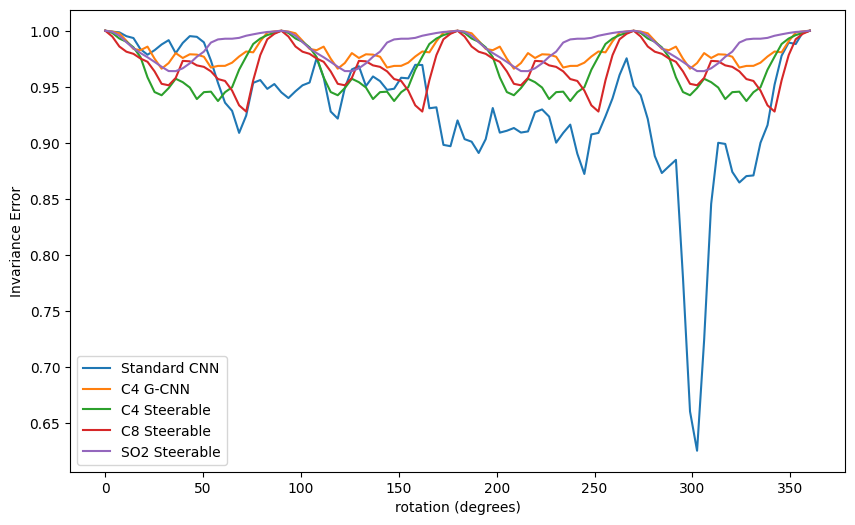

In [346]:
fig, ax = plt.subplots(figsize=(10, 6))

xs = [math.degrees(i*2*np.pi / N) for i in range(N+1)]
for method, error in errors.items():
    plt.plot(xs, error, label=method)

plt.xlabel("rotation (degrees)")
plt.ylabel('Invariance Error')
plt.legend()
plt.show()